Compared to MNIST dataset, CIFAR10 images have 3 channels rather than 1. Also, we use a momentum optimizer with an initial learning rate of 0.01 (decaying by a factor of 0.95 every 390 epochs) and momentum of 0.9, just like in the [ICLR 2017 paper](https://arxiv.org/pdf/1611.03530.pdf). Also, batches sizes are 128 rather than 256.

The CIFAR10 images are also preprocessed via whitening, as described in the above paper.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

import pickle
import time
import tensorflow as tf
import numpy as np

from analysis import *

%matplotlib inline

In [3]:
from get_cifar10 import get_cifar10_dataset
n_samps = 50000

# each value: Xtr, Ytr, Xtt, Ytt
data = {
    'true': get_cifar10_dataset(0, n_samps=n_samps),
    'rand': get_cifar10_dataset(100, n_samps=n_samps)
}
Xtr, Ytr, Xtt, Ytt = data['true']
Ytr_rand, Ytt_rand = data['rand'][1], data['rand'][3]
C2 = np.mean([np.sqrt(np.sum(np.square(i))) for i in Xtr])
gamma = 0.04*C2
eps_wrm = 1./(2*gamma)

### Inception

In [4]:
from spectral_adversarial_regularization.models import inception as model
eps_list = np.linspace(0, 0.0625, 6)*C2
archname = 'inception'

In [5]:
# Estimate eps for the other samples using the perturbation achieved for each test sample
save_dir = os.path.join('save_weights', 'cifar10', 'inception', 'inception_wrm_true')
arch = model.inception

Xtr_adv_wrm = ad.build_graph_and_gen_adv_examples(Xtr, arch, save_dir, beta=1, num_channels=3,
                                                  load_epoch=200, method=ad.wrm, eps=eps_wrm)
    
eps = np.sqrt(np.mean([np.sum(np.square(i)) for i in Xtr_adv_wrm-Xtr])) 
print(eps/C2)

# Note: the above eps/C2 is 0.0020451227, but we'll use 0.002
eps = 0.002*C2

INFO:tensorflow:Restoring parameters from save_weights/cifar10/inception/inception_wrm_true/checkpoints/epoch36
0.00204520484696


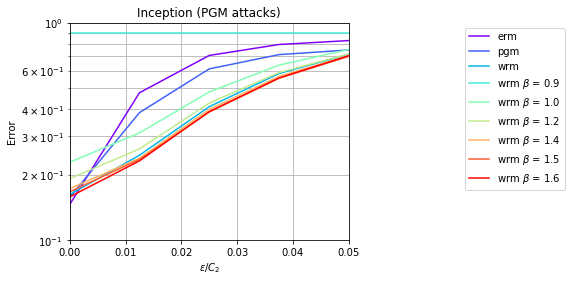

In [12]:
# Evaluate robustness of networks
labeltype = 'true'
arch = model.inception
methods = ['erm', 'pgm', 'wrm']

curves_file = 'save_weights/cifar10/inception/adv_attack_curves.pickle'

if os.path.isfile(curves_file):
    adv_results = pickle.load(file(curves_file, 'rb'))
else:
    adv_results = get_curves_for_arch(data, labeltype, arch, methods, eps_list, archname)
    pickle.dump(adv_results, file(curves_file, 'wb'))
    
# Generate adv attack curves for WRM SN
arch = model.inception_sn
for beta in [1.6, 1.5, 1.4, 0.9, 1.0, 1.2]:
    save_dir = 'save_weights/cifar10/inception/inception_wrm_true_beta%s/'%(beta)
    key = r'wrm $\beta$ = %s'%(beta)
    if key not in adv_results:
        acc, adv_accs = get_adv_acc_curve(Xtt, Ytt, save_dir,
                                          arch, eps_list, order=2, method=ad.pgm,
                                          beta=beta, load_epoch=200, num_channels=3)
        adv_results[key] = (acc, adv_accs, np.NaN)
        
# # Generate plot
# for k in adv_results.keys():
#     if '1.2' in k:
#         adv_results.pop(k)
plot_acc_curves(adv_results, eps_list/C2, title='Inception (PGM attacks)',
                savename='Figures/cifar10_inception_adv_attack_curves',
                ylim=(1e-1, 1e0), xlim=(0, 0.05), diff_methods=True, bigfig=False,
                report_sn=False, report_test=False)

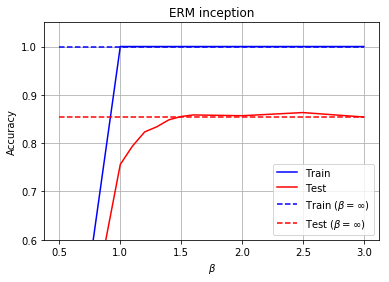

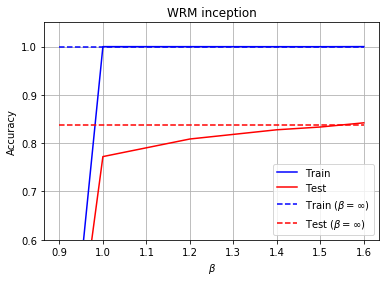

In [198]:
# Get final training and test accuracies
for method in ['erm', 'wrm']:
    train_test_accs_file = 'save_weights/cifar10/inception/%s_train_test_accs.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr, Xtt, Ytt, model.inception_sn, model.inception, adv=method,
                                  load_epoch=200, train_test_accs_file=train_test_accs_file,
                                  num_channels=3, maindir='save_weights/cifar10/inception/')
    plot_train_test_accs(results, logx=False, logy=False, ylim=(0.6, 1.05),
                         savename='Figures/cifar10_inception_train_test_accs_%s'%(method), 
                         title='%s %s'%(method.upper(), archname))

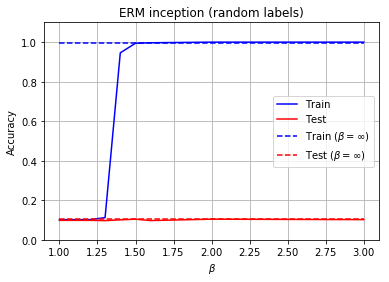

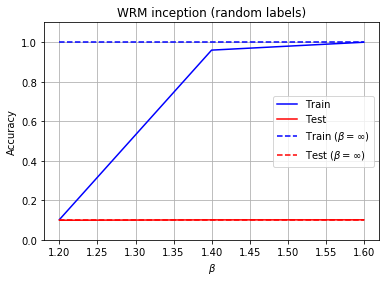

In [211]:
from spectral_adversarial_regularization.models import inception as model

# Get final training and test accuracies for networks trained on random labels
for method in ['erm', 'wrm']:
    train_test_accs_file = 'save_weights/cifar10/inception/%s_train_test_accs_randlabels.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr_rand, Xtt, Ytt_rand, model.inception_sn, model.inception,
                                  adv=method, load_epoch=200, train_test_accs_file=train_test_accs_file,
                                  num_channels=3, maindir='save_weights/cifar10/inception/', randmode=True)
    plot_train_test_accs(results, logy=False, ylim=(0, 1.1), logx=False,
                         savename='Figures/cifar10_inception_train_test_accs_randlabels_%s'%(method),
                         title='%s %s (random labels)'%(method.upper(), archname))

In [ ]:
# Get perturbation curves
curves_file = 'save_weights/cifar10/inception/wrm_perturbation_curves.pickle'
adv_results = get_perturbation_curves(Xtr, Xtt, model.inception_sn, model.inception, 'wrm',
                                      eps_list, load_epoch=200, curves_file=curves_file, 
                                      maindir='save_weights/cifar10/inception/', num_channels=3,
                                      gpu_prop=0.2, skiprand=False, verbose=False)

plot_perturbation_curves(eps_list/C2, adv_results, ylim=None,
                         savename='Figures/cifar10_inception_perturbation_curves_wrm')

plot_perturbation_curves(eps_list/C2, adv_results, ylim=None, mode=2)

### Alexnet

In [38]:
from spectral_adversarial_regularization.models import alexnet as model
eps_list = np.linspace(0, 0.0625, 6)*C2
archname = 'alexnet'

In [6]:
# Estimate eps for the other samples using the perturbation achieved for each test sample
save_dir = os.path.join('save_weights', 'cifar10', 'alexnet', 'alexnet_wrm_true')
arch = model.alexnet

Xtr_adv_wrm = ad.build_graph_and_gen_adv_examples(Xtr, arch, save_dir, beta=1, num_channels=3,
                                                  load_epoch=200, method=ad.wrm, eps=eps_wrm)
    
eps = np.sqrt(np.mean([np.sum(np.square(i)) for i in Xtr_adv_wrm-Xtr])) 
print(eps/C2)

# Note: the above eps/C2 is 0.0016020516, but we'll use 0.0016
eps = 0.0016*C2

INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true/checkpoints/epoch25
0.0016020516226


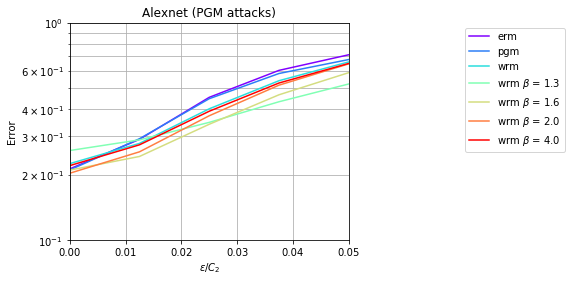

In [39]:
# Evaluate robustness of networks
labeltype = 'true'
arch = model.alexnet
methods = ['erm', 'fgm', 'pgm', 'wrm']

curves_file = 'save_weights/cifar10/alexnet/adv_attack_curves.pickle'

if os.path.isfile(curves_file):
    adv_results = pickle.load(file(curves_file, 'rb'))
else:
    adv_results = get_curves_for_arch(data, labeltype, arch, methods, eps_list, archname)
    pickle.dump(adv_results, file(curves_file, 'wb'))
    
# Generate adv attack curves for WRM SN
arch = model.alexnet_sn
for beta in [1.6, 1.3, 2.0, 4.0]:
    save_dir = 'save_weights/cifar10/alexnet/alexnet_wrm_true_beta%s/'%(beta)
    key = r'wrm $\beta$ = %s'%(beta)
    if key not in adv_results:
        acc, adv_accs = get_adv_acc_curve(Xtt, Ytt, save_dir,
                                          arch, eps_list, order=2, method=ad.pgm,
                                          beta=beta, load_epoch=200, num_channels=3)
        adv_results[key] = (acc, adv_accs, np.NaN)
        
# Make plots
for k in adv_results.keys():
    if 'fgm' in k:
        adv_results.pop(k)
plot_acc_curves(adv_results, eps_list/C2, title='Alexnet (PGM attacks)',
                savename='Figures/cifar10_alexnet_adv_attack_curves',
                ylim=(1e-1, 1e0), xlim=(0, 0.05), diff_methods=True, bigfig=False,
                report_sn=False, report_test=False)

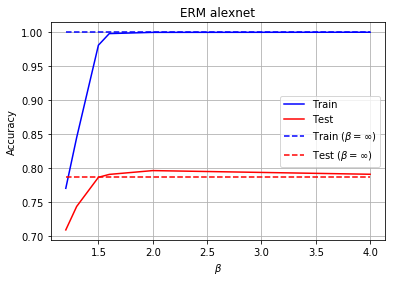

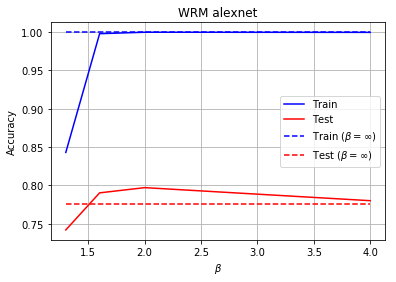

In [46]:
# Get final training and test accuracies
for method in ['erm', 'wrm']:
    train_test_accs_file = 'save_weights/cifar10/alexnet/%s_train_test_accs.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr, Xtt, Ytt, model.alexnet_sn, model.alexnet, adv=method,
                                  load_epoch=200, train_test_accs_file=train_test_accs_file,
                                  num_channels=3, maindir='save_weights/cifar10/alexnet/')
    for i in results.keys():
        if '1.0' in i or '1.1' in i or '0.5' in i:
            results.pop(i)
    plot_train_test_accs(results, logx=False, logy=False, ylim=None,
                         savename='Figures/cifar10_alexnet_train_test_accs_%s'%(method), 
                         title='%s %s'%(method.upper(), archname))

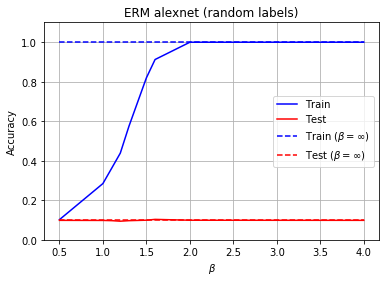

In [47]:
# Get final training and test accuracies for networks trained on random labels
for method in ['erm']:
    train_test_accs_file = 'save_weights/cifar10/alexnet/%s_train_test_accs_randlabels.pickle'%(method)
    results = get_train_test_accs(Xtr, Ytr_rand, Xtt, Ytt_rand, model.alexnet_sn, model.alexnet,
                                  adv=method, load_epoch=200, train_test_accs_file=train_test_accs_file,
                                  num_channels=3, maindir='save_weights/cifar10/alexnet/', randmode=True)
    plot_train_test_accs(results, logx=False, logy=False, ylim=(0, 1.1),
                         savename='Figures/cifar10_alexnet_train_test_accs_randlabels_%s'%(method), 
                         title='%s %s (random labels)'%(method.upper(), archname))

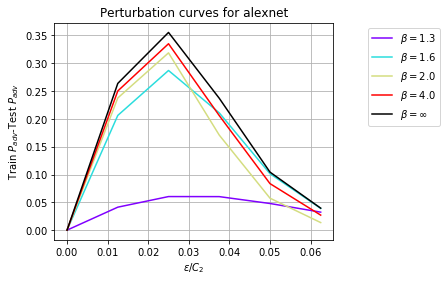

In [48]:
# Get perturbation curves
curves_file = 'save_weights/cifar10/alexnet/wrm_perturbation_curves.pickle'
adv_results = get_perturbation_curves(Xtr, Xtt, model.alexnet_sn, model.alexnet, 'wrm',
                                      eps_list, load_epoch=200, curves_file=curves_file, 
                                      maindir='save_weights/cifar10/alexnet/', num_channels=3,
                                      gpu_prop=0.2, skiprand=True, verbose=False)

plot_perturbation_curves(eps_list/C2, adv_results, ylim=None,
                         title='Perturbation curves for %s'%(archname),
                         savename='Figures/cifar10_alexnet_perturbation_curves_wrm')

In [49]:
def per_image_whitening(images):
    "Mimic tensorflow per_image_whitening"
    orig_shape = images.shape
    images = images.reshape((images.shape[0], -1))
    img_means = np.mean(images, axis=1, keepdims=True)
    img_stds = np.std(images, axis=1, keepdims=True)
    adj_stds = np.maximum(img_stds, 1.0 / np.sqrt(images.shape[1]))
    whiten_imgs = (images - img_means) / adj_stds
    return whiten_imgs.reshape(orig_shape), img_means, adj_stds

def inv_per_image_whitening(images, img_means, adj_stds):
    "Invert whitening operation"
    orig_shape = images.shape
    images = images.reshape((images.shape[0], -1))
    orig_imgs = images * adj_stds + img_means
    return orig_imgs.reshape(orig_shape)

cifar10_label_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird', 
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [50]:
# Look at perturbed images
beta = 1.6
eps = 0.05*C2
n = 10000

import tflearn
datasets = list(tflearn.datasets.cifar10.load_data())
X_, Y_ =  datasets[1][0][:n], datasets[1][1][:n]

# Whiten images
W_, img_means, adj_stds = per_image_whitening(X_)

# Crop
W_ = np.array([i[2:30, 2:30, :] for i in W_])

# For alexnet
arch = model.alexnet
W_adv, Y_adv, inds = perturb_images(W_, eps, arch, 'wrm', n=None, load_epoch=200, method=ad.pgm,
                                    save_dir='save_weights/cifar10/alexnet/alexnet_wrm_true/')
print('Acc on adv examples: %.4f'%(np.sum(Y_adv == Y_)/float(n)))
arch = model.alexnet_sn
W_adv_sn, Y_adv_sn, inds_sn = perturb_images(W_, eps, arch, 'wrm', n=None, load_epoch=200, method=ad.pgm, beta=beta,
                                             save_dir='save_weights/cifar10/alexnet/alexnet_wrm_true_beta%s/'%(beta))
print('Acc on adv examples: %.4f'%(np.sum(Y_adv_sn == Y_)/float(n)))

# Undo cropping
def pad(x):
    return np.pad(x, ((2, 2), (2, 2), (0, 0)), 'constant', constant_values=0)
W_adv = np.array([pad(i) for i in W_adv])
W_adv_sn = np.array([pad(i) for i in W_adv_sn])

# Undo whitening
X_adv = inv_per_image_whitening(W_adv, img_means, adj_stds)
X_adv_sn = inv_per_image_whitening(W_adv_sn, img_means, adj_stds)

# Redo cropping
X_adv = np.array([i[2:30, 2:30, :] for i in X_adv])
X_adv_sn = np.array([i[2:30, 2:30, :] for i in X_adv_sn])

INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true/checkpoints/epoch25
Acc on adv examples: 0.3407
INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true_beta1.6/checkpoints/epoch200
INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true_beta1.6/checkpoints/epoch200
Acc on adv examples: 0.4117


In [51]:
from scipy.stats import itemfreq
itemfreq(map(lambda x: cifar10_label_dict[x], Y_adv_sn))

array([['airplane', '1076'],
       ['automobile', '938'],
       ['bird', '1064'],
       ['cat', '934'],
       ['deer', '1065'],
       ['dog', '929'],
       ['frog', '945'],
       ['horse', '1167'],
       ['ship', '1083'],
       ['truck', '799']],
      dtype='|S21')

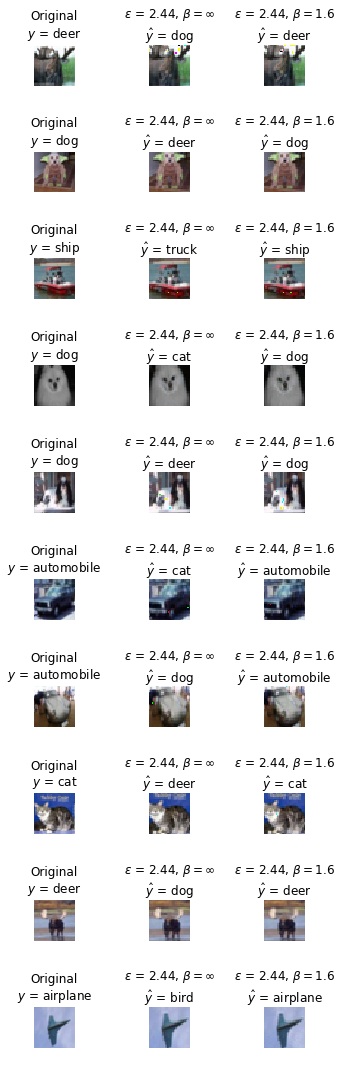

In [65]:
# Look at images where the beta approach does better

n = 10
plt.figure(figsize=(5, n*1.5))

p_count = 0
np.random.seed(0)

inds_of_interest = np.where((Y_ != Y_adv) & (Y_ == Y_adv_sn))[0]

for i in np.random.choice(inds_of_interest, n, replace=False):
    plt.subplot(n, 3, p_count+1)
    plt.imshow(X_[i])
    plt.axis('off')
    plt.title('Original\n$y$ = %s'%(cifar10_label_dict[Y_[i]]))
    plt.subplot(n, 3, p_count+2)
    plt.imshow(X_adv[i], cmap='gray')
    plt.axis('off')
    plt.title(u'$\\epsilon$ = %.2f, $\\beta = \\infty$\n$\^y$ = %s'\
              %(eps, cifar10_label_dict[int(Y_adv[i])]))
    plt.subplot(n, 3, p_count+3)
    plt.imshow(X_adv_sn[i], cmap='gray')
    plt.axis('off')
    plt.title(u'$\\epsilon$ = %.2f, $\\beta = %s$\n$\^y$ = %s'\
              %(eps, beta, cifar10_label_dict[int(Y_adv_sn[i])]))
    p_count += 3
    
plt.tight_layout()
plt.savefig('Figures/cifar10_alexnet_pgm_attacks_sn_v_nosn.pdf',
            format='pdf', dpi=500, bbox_inches='tight')
plt.show()